In [1]:
import pickle
import datetime

import numpy as np

import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.10.5+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.5+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
μ1_pol = couplings.polarization.Polarization(np.array([1, 1, 0]) / np.sqrt(2), "μ12")
μ2_pol = couplings.polarization.Polarization(np.array([-1, 1, 0]) / np.sqrt(2), "μ23")


In [4]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.P, J_ground=2, F1=3 / 2, F=1
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=1,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=3,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
]

polarizations = [
    [couplings.polarization_Z],
    [couplings.polarization_Z, μ1_pol],
    [couplings.polarization_Z, μ2_pol],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [5]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=None,
    decay_channels=None,
    Jmax_X=4,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [6]:
# assuming equal separation
nr_passes = 13
loss_per_pass = 0.15

separation = (np.sqrt(2) * 25.4e-3 + 4e-3) / (nr_passes - 1)

peak_intensity = 2 * 80e-3 / (np.pi * 2e-3 * 10e-3)
peak_intensity1 = 2 * 250e-3 / (np.pi * (25.4e-3 / np.sqrt(2 * np.log(2))) ** 2).item()
peak_intensity2 = 2 * 250e-3 / (np.pi * (25.4e-3 / np.sqrt(2 * np.log(2))) ** 2).item()

pass_nr = np.asarray(utils.multipass.multipas_prism_order(nr_passes))

relative_intensities = (1 - loss_per_pass) ** (pass_nr - 1)

x_locs = np.arange(nr_passes) * separation + 5e-3


In [7]:
# from path tracing and offset by a little to ensure that the 1st laser beam isn't
# clipped by the simulation
x_locs = (
    np.array(
        [
            0.0012572358569496816,
            0.034663788627326955,
            0.007363810019276655,
            0.028557214464999987,
            0.013470384181603614,
            0.022450640302673037,
            0.019576958343930535,
            0.016344066140346142,
            0.025683532506257437,
            0.010237491978019249,
            0.031790106668584305,
            0.004130917815692418,
            0.03789668083091111,
        ]
    )
    + 0.004
)
x_locs.sort()


In [8]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)
v_to_Γ_μ = 0

odepars = lindblad_julia.odeParameters(
    Ω0=(
        "phase_modulation(t, β, ωphase) *"
        " multipass_2d_rabi(z0+vz*t, y0+vy*t, peak_intensity*relative_intensities, xlocs, ylocs, σz, σy, main_coupling)"
    ),
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0.0,  # laser phase modulation depth [rad]
    PZ0=1,
    # J=1 -> J=2 microwaves
    Ω1="gaussian_beam_rabi(z0+vz*t, y0+vy*t, peak_intensity1, xloc1, 0.0, σ1, σ1,main_coupling1, 1.4103753e-29)",
    δ1=f"vx*{v_to_Γ_μ}",
    P1="sin(ω1*t + φ1)",
    PZ1="P1>0",
    Pμ121="P1<=0",
    ω1=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # J=2 -> J=3 microwaves
    Ω2="gaussian_beam_rabi(z0+vz*t, y0+vy*t, peak_intensity2, xloc2, 0.0, σ2, σ2,main_coupling2, 1.4103753e-29)",
    # Ω2=0.1 * hamiltonian.Γ,
    δ2=f"vx*{v_to_Γ_μ}",
    P2="sin(ω2*t + φ2)",
    PZ2="P2>0",
    Pμ232="P2<=0",
    ω2=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ2=np.pi / 2,  # polarization switching phase [rad]
    # molecules
    z0=0.0,  # molecule start z position [m]
    y0=0.0,
    vz=184.0,  # longitudinal molecular velocity [m/s]
    vx=0.0,
    vy=0.0,
    relative_intensities=relative_intensities,
    peak_intensity=peak_intensity,
    peak_intensity1=peak_intensity1,
    peak_intensity2=peak_intensity2,
    xlocs=x_locs,
    xloc1=x_locs[nr_passes // 2].item(),
    xloc2=x_locs[nr_passes // 2].item(),
    ylocs=np.zeros(nr_passes),
    σz=2e-3 / 2,
    σy=10e-3 / 2,
    σ1=25.4e-3 / (2 * np.sqrt(2 * np.log(2)).item()),
    σ2=25.4e-3 / (2 * np.sqrt(2 * np.log(2)).item()),
    main_coupling=float(obe_system.couplings[0].main_coupling.real),
    main_coupling1=float(obe_system.couplings[1].main_coupling.real),
    main_coupling2=float(obe_system.couplings[2].main_coupling.real),
)

In [9]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break


ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    
ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [10]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 3/2, F = 1>"
states,
"|X, J = 0>",0.484131
"|X, J = 2>",0.515869


In [11]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)
indices_J0_F0 = states.QuantumSelector(
    J=0, F=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J0_F1 = states.QuantumSelector(
    J=0, F=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1_F2 = states.QuantumSelector(
    J=1, F=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2_F3 = states.QuantumSelector(
    J=2, F=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3_F4 = states.QuantumSelector(
    J=3, F=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [12]:
ρ = utils.population.generate_thermal_population_states(6.3, obe_system.QN)
ρ /= np.trace(ρ)

In [13]:
odepars.σz = 1e-3
odepars.σy = 5e-3
odepars.peak_intensity = 2 * 70e-3 / (np.pi * (2 * odepars.σz) * (2 * odepars.σy))
odepars.β = 4.0
odepars.ωphase = hamiltonian.Γ

loss_per_pass = 0.15
odepars.relative_intensities = (1 - loss_per_pass) ** (pass_nr - 1)

odepars.y0 = 0.0

odepars.σ1 = 25.4e-3 / (2 * np.sqrt(2 * np.log(2))).item()
odepars.σ2 = 25.4e-3 / (2 * np.sqrt(2 * np.log(2))).item()

odepars.peak_intensity = 2 * 70e-3 / (np.pi * 2e-3 * 10e-3)
odepars.peak_intensity1 = 2 * 250e-3 / (np.pi * (2 * odepars.σ1) ** 2)
odepars.peak_intensity2 = 2 * 250e-3 / (np.pi * (2 * odepars.σ1) ** 2)

odepars.ω1 = 2 * np.pi * 1e6
odepars.ω2 = 2 * np.pi * 1e6
odepars.ϕ1 = 0.0
odepars.ϕ2 = np.pi / 2

In [14]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass
callback = lindblad_julia.setup_discrete_callback_terminate(odepars, "z0+vz*t > 50e-3")

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 400e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6,
    callback=callback,
    reltol=1e-3,
    abstol=1e-7,
    save_everystep=True,
)

In [15]:
results = lindblad_julia.do_simulation_single(problem, config=config)

28.50701316999059


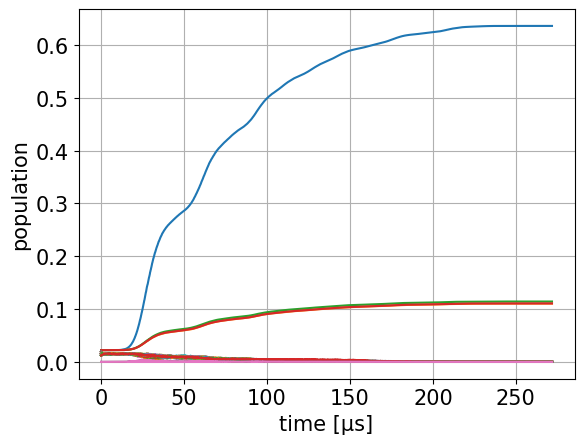

In [16]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y.T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

print(results.y[0, -1] / results.y[0, 0])

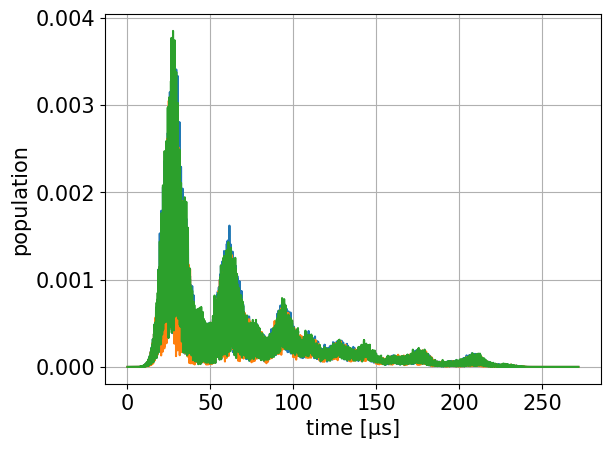

In [17]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

# Parameter Scan

In [18]:
# 1/e^2 diameter of 1.5mm and 1cm for z, y respectively
# going from 1/e^2 diameter (2w) to sigma is given by w=2sigma
odepars.σz = 1.5e-3 / 2
odepars.σy = 10e-3 / 2
odepars.peak_intensity = 2 * 70e-3 / (np.pi * (2 * odepars.σz) * (2 * odepars.σy))
odepars.β = 4.0
odepars.ωphase = hamiltonian.Γ

loss_per_pass = 0.15
odepars.relative_intensities = (1 - loss_per_pass) ** (pass_nr - 1)

odepars.y0 = 0.0

odepars.σ1 = 25.4e-3 / (2 * np.sqrt(2 * np.log(2))).item()
odepars.σ2 = 25.4e-3 / (2 * np.sqrt(2 * np.log(2))).item()

odepars.peak_intensity1 = 2 * 250e-3 / (np.pi * (2 * odepars.σ1) ** 2)
odepars.peak_intensity2 = 2 * 250e-3 / (np.pi * (2 * odepars.σ1) ** 2)

loss_per_pass = 0.15
relative_intensities = (1 - loss_per_pass) ** (pass_nr - 1)
odepars.relative_intensities = relative_intensities


In [19]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

vxs = np.linspace(0, 4, 11)
vzs = np.linspace(184 - 2 * 16, 184 + 2 * 16, 11)
y0s = np.linspace(0, 5e-3, 6)
laser_intensities = (
    np.logspace(-3, 0, 12) * 2 / (np.pi * (2 * odepars.σz) * (2 * odepars.σy))
)

In [20]:
sim_time = datetime.datetime.now().replace(microsecond=0).isoformat().replace(":", "-")

In [21]:
from julia import Main

function_str = f"""
@everywhere function output_func(sol, i)
    open("output_{sim_time}.csv", "a") do file
        println(file, repr(append!([Float64(i)], real(last(sol)))))
    end
    real(last(sol)), false
end"""

Main.eval(function_str)
output_function = lindblad_julia.utils_solver.OutputFunction(
    name="output_func", function=function_str
)


In [22]:
callback = lindblad_julia.setup_discrete_callback_terminate(odepars, "z0+vz*t > 50e-3")
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    distributed_method="EnsembleDistributed()",
    save_everystep=False,
    save_idxs=save_idxs,
    callback=callback,
    reltol=1e-3,
    abstol=1e-6,
)


problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 400e-6))

scan_values = [vxs, vzs, y0s, laser_intensities]
parameters = ["vx", "vz", "y0", "peak_intensity"]

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_function,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

In [23]:
def setup_prob_func(
    name: str, odepars: lindblad_julia.odeParameters, i_offset: int = 0
) -> lindblad_julia.utils_solver.ProblemFunction:
    pars = list(odepars.p)
    for idN, parameter in enumerate(parameters):
        if isinstance(parameter, (list, tuple)):
            indices = [odepars.get_index_parameter(par) for par in parameter]
        else:
            indices = [odepars.get_index_parameter(parameter)]
        for idx in indices:
            if i_offset == 0:
                pars[idx] = f"params[i,{idN+1}]"
            else:
                pars[idx] = f"params[i+{i_offset}, {idN+1}]"

    _pars = (
        "("
        + ",".join(
            [
                repr(pi).replace("array", "").replace("(", "").replace(")", "")
                if type(pi) == np.ndarray
                else str(pi)
                for pi in pars
            ]
        )
        + ")"
    )
    function_str = f"""
    @everywhere function prob_func(prob, i, repeat)
        remake(prob, p = {_pars})
    end
    """
    return lindblad_julia.utils_solver.ProblemFunction(name=name, function=function_str)


In [24]:
prob_func = setup_prob_func("prob_func", odepars)
Main.eval(prob_func.function)
Main.eval(f"""
ens_{ensemble_problem.problem.name} = EnsembleProblem(
    {ensemble_problem.problem.name},
    prob_func = prob_func,
    output_func = {output_function.name})
""")


<PyCall.jlwrap EnsembleProblem{ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Tuple{Float64, Float64, Int64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Vector{Float64}, Float64, Float64, Float64, Vector{Float64}, Float64, Float64, Vector{Float64}, Vararg{Float64, 7}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, typeof(prob_func), typeof(output_func), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}(ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Tuple{Float64, Float64, Int64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Vector{Float64}, Float64, Float64, Float64, Vector{Float64}, Float64, Flo

In [25]:
import time
import threading
from pathlib import Path

import tqdm


class ProgressBar(threading.Thread):
    def __init__(self, fname: Path, total_iterations: int):
        super().__init__()
        self.fname = fname
        self.total_iterations = total_iterations
        self.active = threading.Event()

    def run(self):
        progress = 0
        total_iterations = self.total_iterations
        self.active.set()

        with tqdm.tqdm(
            total=total_iterations, desc="Simulating", unit="iteration"
        ) as pbar:
            while self.active.isSet():
                if self.fname.exists():
                    with open(self.fname, "r") as f:
                        total = len(f.readlines())
                    pbar.update(total - progress)
                    progress = total
                    if progress >= total_iterations:
                        break
                time.sleep(5)


In [26]:
fname = Path(f"output_{sim_time}.csv")
print(fname)


output_2024-10-07T23-59-09.csv


In [27]:
%%time
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


CPU times: total: 2min 21s
Wall time: 23h 2min 41s


In [29]:
try:
    _trajectories = np.prod([len(v) for v in ensemble_problem.scan_values])
    values = np.array([Main.eval(f"sol.u[{idx+1}]") for idx in range(_trajectories)])
except Exception as e:
    file_data = np.loadtxt(
        fname, delimiter=",", converters=lambda l: l.strip("[").strip("]")
    )
    file_data = file_data[file_data[:, 0].argsort()]
    file_data[:, 0]
    values = file_data[:, 1:]
    assert len(values) == _trajectories
    del file_data


In [30]:
with open(f"params_{sim_time}.csv", "w") as f:
    f.write(",".join(parameters) + "\n")
    for line in Main.params:
        f.write(",".join([str(v) for v in line]) + "\n")

with open(f"config_{sim_time}.txt", "w") as f:
    f.write(str(odepars) + "\n\n")
    f.write(str(ensemble_config) + "\n\n")
    f.write(f"tspan={ensemble_problem.problem.tspan}\n")
    f.write(output_function.function)
    f.write("\n")
    f.write(callback.function)
    f.write("\n")

with open(f"function_{sim_time}.jl", "w") as f:
    f.write(obe_system.preamble)
    for line in obe_system.code_lines:
        f.write("\t\t" + line + "\n")
    f.write("\t end \n \t nothing \n end")

with open(f"simulation_{sim_time}.pkl", "wb") as f:
    pickle.dump(
        {
            "obe_system": obe_system,
            "problem": problem,
            "ensemble_config": ensemble_config,
            "ensemble_problem": ensemble_problem,
            "scan_values": scan_values,
            "parameters": parameters,
        },
        f,
    )

np.savetxt(
    f"output_{sim_time}_final.csv",
    np.hstack([np.arange(1, len(values) + 1).reshape(-1, 1), values]),
    delimiter=",",
)


In [31]:
from julia import Main

res = values.reshape(
    [len(v) for v in ensemble_problem.scan_values][::-1] + [values.shape[-1]]
).T

results_scan = lindblad_julia.OBEResultParameterScan(
    parameters=ensemble_problem.parameters,
    scan_values=np.meshgrid(*ensemble_problem.scan_values, indexing="ij"),
    results=res,
    zipped=False,
)

# Interpolate and use simulated trajectory values

In [32]:
fname_trajectories = Path() / "coords_vels_rc.npy"
# x, y, z, vx, vy, vz
coords_vels = np.load(fname_trajectories)


In [33]:
from scipy import interpolate


interpolator = interpolate.RegularGridInterpolator(
    points=ensemble_problem.scan_values,
    values=results_scan.results[0, :, :, :, :],
    method="linear",
    bounds_error=False,
    fill_value=np.nan,
)


In [34]:
params = Main.params


In [35]:
# test if the interpolation worked
for _ in range(1_000):
    choice = np.random.randint(0, len(values))
    if not np.isclose(interpolator(params[choice]).item(), values[choice, 0]):
        print(_)
        print(interpolator(params[choice]).item())
        print(values[choice, 0])
        raise ValueError()

# doesn't work because it uses a spline interpolation, so it deviates slightly


In [36]:
# scan values are ["vx", "vz", "y0", "peak_intensity"]
gain = []
for intensity in ensemble_problem.scan_values[-1]:
    c = np.hstack(
        (coords_vels[:, [3, 5, 1]], np.ones((len(coords_vels), 1)) * intensity)
    )
    # since we are centered around y=0 negative y values weren't simulated, use abs(y)
    # so the interpolator works properly.
    # same goes for vx
    c[:, 2] = np.abs(c[:, 2])
    c[:, 0] = np.abs(c[:, 0])
    gain.append(interpolator(c))

gain = np.array(gain)


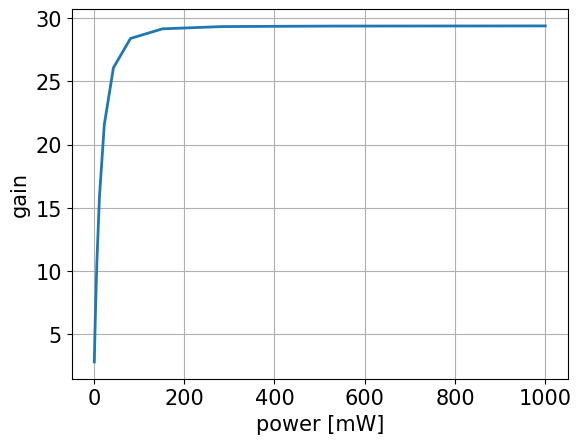

In [37]:
intensity_to_power = 2 / (np.pi * (2 * odepars.σz) * (2 * odepars.σy))

fig, ax = plt.subplots()

ax.plot(
    ensemble_problem.scan_values[-1] / intensity_to_power * 1e3,
    np.nanmean(gain, axis=1) / ρ[0, 0].real,
    lw=2,
)

ax.set_xlabel("power [mW]")
ax.set_ylabel("gain")

ax.grid()


In [38]:
# scan values are ["vx", "vz", "y0", "peak_intensity"]
gain = []
powers = np.linspace(1, 100, 101) * 1e-3
for power in powers:
    intensity = power * intensity_to_power
    c = np.hstack(
        (coords_vels[:, [3, 5, 1]], np.ones((len(coords_vels), 1)) * intensity)
    )
    # since we are centered around y=0 negative y values weren't simulated, use abs(y)
    # so the interpolator works properly.
    # same goes for vx
    c[:, 2] = np.abs(c[:, 2])
    c[:, 0] = np.abs(c[:, 0])
    gain.append(interpolator(c))

gain = np.array(gain)


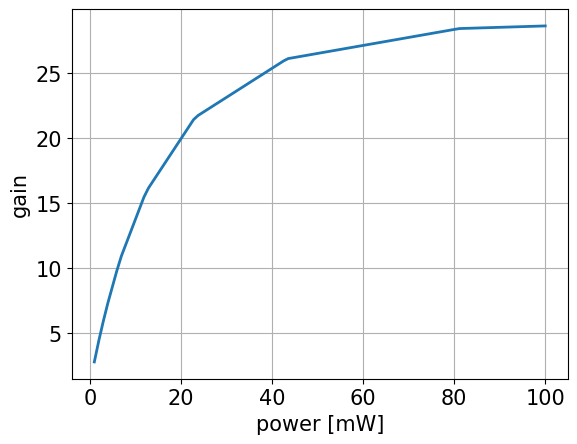

In [39]:
intensity_to_power = 2 / (np.pi * (2 * odepars.σz) * (2 * odepars.σy))

fig, ax = plt.subplots()

ax.plot(
    powers * 1e3,
    np.nanmean(gain, axis=1) / ρ[0, 0].real,
    lw=2,
)

ax.set_xlabel("power [mW]")
ax.set_ylabel("gain")

ax.grid()


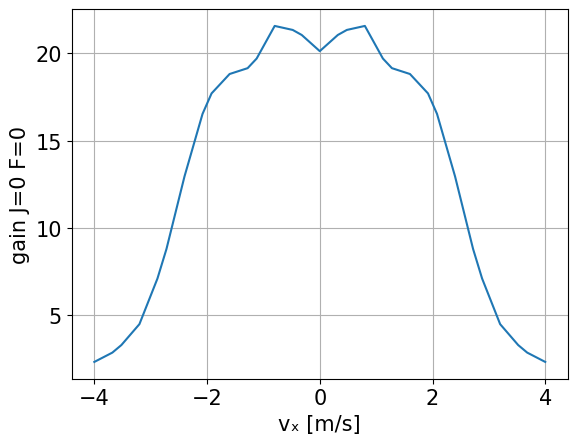

In [40]:
power = 20e-3
x = np.linspace(-4, 4, 51)
fig, ax = plt.subplots()
ax.plot(
    x,
    interpolator(
        np.array(
            [
                np.abs(x),
                np.ones(len(x)) * 184,
                np.ones(len(x)) * 1e-3,
                np.ones(len(x)) * power * intensity_to_power,
            ]
        ).T
    )
    / ρ[0, 0].real,
)
ax.set_xlabel("vₓ [m/s]")
ax.set_ylabel("gain J=0 F=0")
ax.grid()
